# UNet++

# 목차

1. [Imports & Global Constants](#Imports-&-Global-Constants): 학습에 필요한 라이브러리들을 임포트 하고 미션 안에서 이루어지는 학습 전반을 컨트롤 하기 위한 파라미터들을 설정합니다.
2. [Check the Size of the Dataset](#Check-the-Size-of-the-Dataset): 학습에 사용될 데이터가 잘 준비되어있는지 확인합니다.
3. [Define Dataset Class](#Define-Dataset-Class): 데이터를 원하는 형태로 불러오기 위한 Dataset 클래스를 정의하고, validation을 위한 데이터 스플릿을 진행합니다.
4. [Check Data Sample](#Check-Data-Sample): 제공된 데이터가 어떤 모습인지 확인합니다.
5. [Setup Dataloader](#Setup-Dataloader): 학습을 위해 데이터를 배치로 불러오기 위한 Dataloader를 만듭니다.
6. [Define Functions for Training](#Define-Functions-for-Training): 학습을 도와주는 함수들을 정의합니다.
7. [Training](#Training): 학습을 진행합니다.
8. [Inference](#Inference): 인퍼런스에 필요한 함수들을 정의하고, 인퍼런스를 진행합니다.
9. [Result Visualization](#Result-Visualization): 인퍼런스 결과를 확인해봅니다.
10. [To CSV](#To-CSV): 인퍼런스 결과를 제출을 위한 포맷으로 변경합니다.

# Imports & Global Constants

In [1]:
#pip install 'git+https://github.com/katsura-jp/pytorch-cosine-annealing-with-warmup'

In [ ]:
#pip install torch-optimizer

: 

In [ ]:
# python native
import os
import json
import random
import datetime
from functools import partial

# external library
import cv2
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.model_selection import GroupKFold
import albumentations as A
from albumentations.pytorch import ToTensorV2 
import segmentation_models_pytorch as smp 
from cosine_annealing_warmup import CosineAnnealingWarmupRestarts #custom learning rate scheduler


# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
#import torch.optim as optim adamW
import torch_optimizer as optim #adamP
from torch.utils.data import Dataset, DataLoader
# from torchvision import models 

# visualization
import matplotlib.pyplot as plt

/data/ephemeral/home/rjy/py310_jy/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


: 

In [ ]:
# 데이터 경로를 입력하세요

TRAIN_IMAGE_ROOT = "../data/train/DCM"
TRAIN_LABEL_ROOT = "../data/train/outputs_json"
TEST_IMAGE_ROOT  = "../data/test/DCM"
META_DATA_PATH = "../data/meta_data.xlsx" 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

: 

In [ ]:
CLASSES = [
    'finger-1', 'finger-2', 'finger-3', 'finger-4', 'finger-5',
    'finger-6', 'finger-7', 'finger-8', 'finger-9', 'finger-10',
    'finger-11', 'finger-12', 'finger-13', 'finger-14', 'finger-15',
    'finger-16', 'finger-17', 'finger-18', 'finger-19', 'Trapezium',
    'Trapezoid', 'Capitate', 'Hamate', 'Scaphoid', 'Lunate',
    'Triquetrum', 'Pisiform', 'Radius', 'Ulna',
]

: 

In [ ]:
CLASS2IND = {v: i for i, v in enumerate(CLASSES)}

: 

In [ ]:
IND2CLASS = {v: k for k, v in CLASS2IND.items()}

: 

In [ ]:
IMAGE_SIZE = 1024 # 1024x1024
BATCH_SIZE = 2
LR = 5e-4
RANDOM_SEED = 21

NUM_EPOCHS = 30
VAL_EVERY = 1

SAVED_DIR = "checkpoints"

if not os.path.exists(SAVED_DIR):                                                           
    os.makedirs(SAVED_DIR)

: 

# Check the Size of the Dataset

`IMAGE_ROOT` 아래에 있는 모든 폴더를 재귀적으로 순회하면서 확장자가 `.png`인 파일들을 찾습니다.

In [ ]:
pngs = {
    os.path.relpath(os.path.join(root, fname), start=TRAIN_IMAGE_ROOT)
    for root, _dirs, files in os.walk(TRAIN_IMAGE_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".png"
}

: 

In [ ]:
len(pngs)

800

: 

마찬가지로 `LABEL_ROOT` 아래에 있는 모든 폴더를 재귀적으로 순회하면서 확장자가 `.json`인 파일들을 찾습니다.

In [ ]:
jsons = {
    os.path.relpath(os.path.join(root, fname), start=TRAIN_LABEL_ROOT)
    for root, _dirs, files in os.walk(TRAIN_LABEL_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".json"
}

: 

In [ ]:
len(jsons)

800

: 

모든 `.png` 파일에 대해 `.json` pair가 존재하는지 체크합니다. 파일명에서 확장자를 제거한 set을 생성하고 두 집합의 차집합의 크기가 0인지 확인합니다.

In [ ]:
jsons_fn_prefix = {os.path.splitext(fname)[0] for fname in jsons}
pngs_fn_prefix = {os.path.splitext(fname)[0] for fname in pngs}

assert len(jsons_fn_prefix - pngs_fn_prefix) == 0
assert len(pngs_fn_prefix - jsons_fn_prefix) == 0

: 

모든 `.png` 파일에 대해 label이 존재하는 것을 확인했습니다. 이름 순으로 정렬해서 짝이 맞도록 합니다.

In [ ]:
pngs = sorted(pngs)
jsons = sorted(jsons)

: 

In [ ]:
from sklearn.model_selection import GroupKFold

# 그룹 설정: 파일명에서 폴더 경로를 제외한 '파일명' 자체를 그룹으로 사용 (또는 폴더명 사용)
# Baseline 코드에서는 `os.path.dirname(fname)`을 그룹으로 썼네요. 그대로 따르겠습니다.
# (만약 한 폴더에 한 환자의 이미지가 다 들어있다면 이 방식이 맞습니다.)
groups = [os.path.dirname(fname) for fname in pngs] 

# 5-Fold GroupKFold 객체 생성
gkf = GroupKFold(n_splits=5)

# 첫 번째 Fold만 사용 (0번 인덱스)
train_pngs = []
train_jsons = []
valid_pngs = []
valid_jsons = []

# split 함수는 generator이므로 한 번만 돌리고 break
for i, (train_idx, val_idx) in enumerate(gkf.split(pngs, jsons, groups)):
    # i == 0 일 때만 가져오고 탈출
    if i == 0:
        train_pngs = [pngs[k] for k in train_idx]
        train_jsons = [jsons[k] for k in train_idx]
        
        valid_pngs = [pngs[k] for k in val_idx]
        valid_jsons = [jsons[k] for k in val_idx]
        break

print(f"\n[GroupKFold Split Complete]")
print(f"Train Dataset: {len(train_pngs)} images")
print(f"Valid Dataset: {len(valid_pngs)} images")


[GroupKFold Split Complete]
Train Dataset: 640 images
Valid Dataset: 160 images


: 

In [ ]:
WRIST_CLASSES = [
    "Trapezium", "Trapezoid", "Capitate", "Hamate",
    "Scaphoid", "Lunate", "Triquetrum", "Pisiform",
]
WRIST_INDICES = [CLASS2IND[c] for c in WRIST_CLASSES if c in CLASS2IND]

def crop_wrist_roi(image, mask_hwc, wrist_indices, min_size=128, margin_frac=0.1):
    """
    image: (H, W, 3)
    mask_hwc: (H, W, C)
    wrist_indices: 손목 클래스 인덱스 리스트 (채널 인덱스)
    min_size: 너무 작은 bbox면 무시하기 위한 최소 크기 (pixels)
    margin_frac: bbox 주변에 추가로 붙일 margin 비율 (0.1 = 10%)
    """
    H, W = image.shape[:2]

    if len(wrist_indices) == 0:
        return image, mask_hwc  # 손목 클래스 없으면 원본 그대로

    # (H, W, C) → (C, H, W) 로 바꿔서 필요한 채널만 선택
    mask_chw = mask_hwc.transpose(2, 0, 1)  # (C, H, W)
    wrist_mask = mask_chw[wrist_indices, ...]  # (num_wrist, H, W)

    # union mask: 손목 클래스 전체 OR
    union = wrist_mask.sum(axis=0) > 0  # (H, W), bool

    if not union.any():
        # 이 이미지에 손목 클래스가 없으면 crop 안 함
        return image, mask_hwc

    ys, xs = np.where(union)
    y_min, y_max = ys.min(), ys.max()
    x_min, x_max = xs.min(), xs.max()

    # 너무 작은 영역이면 crop 안 하는 것도 한 방법
    if (y_max - y_min + 1) < min_size or (x_max - x_min + 1) < min_size:
        return image, mask_hwc

    # margin 추가 (비율 기준)
    h_box = y_max - y_min + 1
    w_box = x_max - x_min + 1
    dy = int(h_box * margin_frac)
    dx = int(w_box * margin_frac)

    ya = max(0, y_min - dy)
    yb = min(H, y_max + dy)
    xa = max(0, x_min - dx)
    xb = min(W, x_max + dx)

    image_crop = image[ya:yb, xa:xb]
    mask_crop = mask_hwc[ya:yb, xa:xb]

    return image_crop, mask_crop

: 

# Define Dataset Class

In [ ]:
class XRayDataset(Dataset):
    def __init__(
        self,
        image_root,
        label_root,
        istrain=True,
        transforms=None,
        filenames=None,
        labelnames=None,
    ):
        self.image_root = image_root
        self.label_root = label_root

        self.filenames = filenames
        self.labelnames = labelnames
        self.istrain = istrain
        self.transforms = transforms

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, item):
        imagename = self.filenames[item]
        imagepath = os.path.join(self.image_root, imagename)

        image = cv2.imread(imagepath)
        if image is None:
            raise FileNotFoundError(f"cv2.imread failed: {imagepath}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        labelname = self.labelnames[item]
        labelpath = os.path.join(self.label_root, labelname)

        H, W = image.shape[:2]

        # 1) mask는 (C,H,W)로 만들고 채널 단위로 in-place fillPoly
        mask_chw = np.zeros((len(CLASSES), H, W), dtype=np.uint8)

        with open(labelpath, "r") as f:
            ann = json.load(f)

        for a in ann.get("annotations", []):
            c = a["label"]
            if c not in CLASS2IND:
                continue
            ci = CLASS2IND[c]
            pts = np.array(a["points"], dtype=np.int32).reshape(-1, 1, 2)

            cv2.fillPoly(mask_chw[ci], [pts], 1)

        # 2) augment는 (H,W,C)로 진행
        mask = mask_chw.transpose(1, 2, 0)  # (H,W,C)

        if self.transforms is not None:
            out = self.transforms(image=image, mask=mask)
            image = out["image"]
            mask = out["mask"].float()

        return image, mask


: 

In [ ]:
from torch.utils.data import Dataset, ConcatDataset

class WristCropDataset(Dataset):
    def __init__(
        self,
        image_root,
        label_root,
        transforms=None,
        filenames=None,
        labelnames=None,
    ):
        self.image_root = image_root
        self.label_root = label_root
        self.filenames = filenames
        self.labelnames = labelnames
        self.transforms = transforms

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, item):
        imagename = self.filenames[item]
        imagepath = os.path.join(self.image_root, imagename)

        image = cv2.imread(imagepath)
        if image is None:
            raise FileNotFoundError(f"cv2.imread failed: {imagepath}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        labelname = self.labelnames[item]
        labelpath = os.path.join(self.label_root, labelname)

        H, W = image.shape[:2]
        mask_chw = np.zeros((len(CLASSES), H, W), dtype=np.uint8)

        with open(labelpath, "r") as f:
            ann = json.load(f)

        for a in ann.get("annotations", []):
            c = a["label"]
            if c not in CLASS2IND:
                continue
            ci = CLASS2IND[c]
            pts = np.array(a["points"], dtype=np.int32).reshape(-1, 1, 2)
            cv2.fillPoly(mask_chw[ci], [pts], 1)

        # (H, W, C)
        mask = mask_chw.transpose(1, 2, 0)

        # === 여기서 손목 ROI crop 적용 ===
        image, mask = crop_wrist_roi(
            image,
            mask,
            wrist_indices=WRIST_INDICES,
            min_size=128,
            margin_frac=0.15,
        )

        if self.transforms is not None:
            out = self.transforms(image=image, mask=mask)
            image = out["image"]
            mask = out["mask"].float()

        return image, mask


: 

# Check Data Sample

In [ ]:
# 시각화를 위한 팔레트를 설정합니다.
PALETTE = [
    (220, 20, 60), (119, 11, 32), (0, 0, 142), (0, 0, 230), (106, 0, 228),
    (0, 60, 100), (0, 80, 100), (0, 0, 70), (0, 0, 192), (250, 170, 30),
    (100, 170, 30), (220, 220, 0), (175, 116, 175), (250, 0, 30), (165, 42, 42),
    (255, 77, 255), (0, 226, 252), (182, 182, 255), (0, 82, 0), (120, 166, 157),
    (110, 76, 0), (174, 57, 255), (199, 100, 0), (72, 0, 118), (255, 179, 240),
    (0, 125, 92), (209, 0, 151), (188, 208, 182), (0, 220, 176),
]

# 시각화 함수입니다. 클래스가 2개 이상인 픽셀을 고려하지는 않습니다.
def label2rgb(label):
    image_size = label.shape[1:] + (3, )
    image = np.zeros(image_size, dtype=np.uint8)
    
    for i, class_label in enumerate(label):
        image[class_label == 1] = PALETTE[i]
        
    return image

: 

In [ ]:
'''
train_tf = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),

    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(
        shift_limit=0.05, scale_limit=0.05, rotate_limit=0,
        border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=0, p=1.0
    ),
    A.GridDistortion(num_steps=5, distort_limit=0.05, p=0.3),

    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.3),
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.3),
    A.RandomGamma(gamma_limit=(80, 120), p=0.3),
    A.GaussNoise(var_limit=(5.0, 10.0), p=1.0),

    A.Normalize(),
    ToTensorV2(transpose_mask=True),
])
'''
train_tf = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),

    # Geometric (약하게)
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(
        shift_limit=0.03, scale_limit=0.03, rotate_limit=3,
        border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=0, p=0.5
    ),
    # GridDistortion는 일단 off, 필요하면 아주 약하게 추가

    # Photometric (약하게, 확률 낮게)
    A.RandomBrightnessContrast(brightness_limit=0.05, contrast_limit=0.05, p=0.2),
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.2),
    A.RandomGamma(gamma_limit=(90, 110), p=0.2),
    A.GaussNoise(var_limit=(1.0, 5.0), p=0.3),

    A.Normalize(),
    ToTensorV2(transpose_mask=True),
])


valid_tf = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.Normalize(),
    ToTensorV2(transpose_mask=True),
])

: 

In [ ]:
train_dataset = XRayDataset(
    image_root=TRAIN_IMAGE_ROOT,
    label_root=TRAIN_LABEL_ROOT,
    istrain=True,
    transforms=train_tf,
    filenames=train_pngs,
    labelnames=train_jsons,
)
'''
train_dataset_wrist = WristCropDataset(
    image_root=TRAIN_IMAGE_ROOT,
    label_root=TRAIN_LABEL_ROOT,
    transforms=train_tf,
    filenames=train_pngs,
    labelnames=train_jsons,
)

train_dataset = ConcatDataset([train_dataset_full, train_dataset_wrist])
'''
valid_dataset = XRayDataset(
    image_root=TRAIN_IMAGE_ROOT,
    label_root=TRAIN_LABEL_ROOT,
    istrain=False,
    transforms=valid_tf,
    filenames=valid_pngs,
    labelnames=valid_jsons,
)

: 

In [ ]:
image, label = train_dataset[21]

: 

In [ ]:
print(image.shape, label.shape)

torch.Size([3, 512, 512]) torch.Size([29, 512, 512])


: 

In [ ]:
len(train_dataset)

640

: 

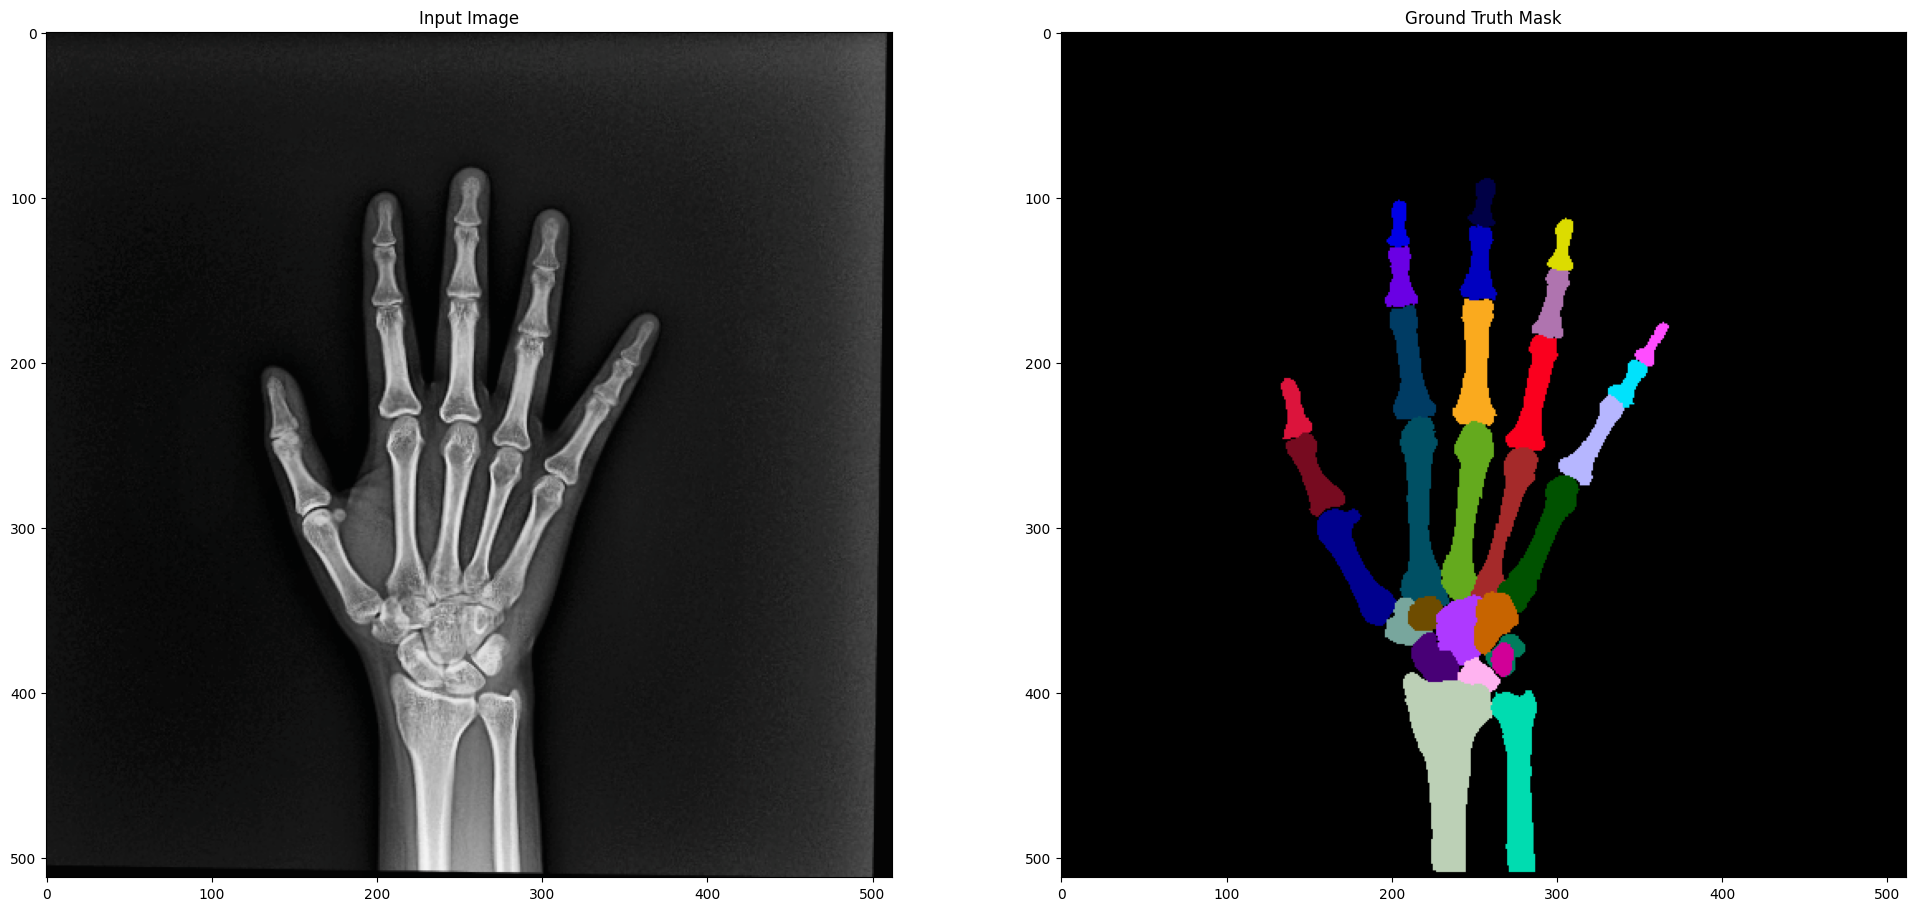

: 

In [ ]:
# 1. Image: Tensor (C, H, W) -> Numpy (H, W, C) 로 바꿔야 plt.imshow 가능
if isinstance(image, torch.Tensor):
    # (C, H, W) -> (H, W, C)
    image_show = image.permute(1, 2, 0).cpu().numpy()
    
    # Normalize 되돌리기 (시각화를 위해)
    # (Mean, Std가 기본값 (0.485, ...) 이라고 가정)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image_show = std * image_show + mean
    image_show = np.clip(image_show, 0, 1)
else:
    image_show = image

# 2. Label: Tensor -> Numpy (C, H, W) 유지
if isinstance(label, torch.Tensor):
    label_show = label.cpu().numpy()
else:
    label_show = label

# 만약 여기서도 에러가 나면 label 모양이 (H, W, C)인지 확인
if label_show.ndim == 3 and label_show.shape[-1] == 29:
    label_show = label_show.transpose(2, 0, 1)

# --- 그리기 ---
fig, ax = plt.subplots(1, 2, figsize=(24, 12))
ax[0].imshow(image_show)
ax[0].set_title("Input Image")
ax[1].imshow(label2rgb(label_show))
ax[1].set_title("Ground Truth Mask")
plt.show()

# Setup Dataloader

In [ ]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=4,
    drop_last=True,
)

val_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,      # <- 일단 여기
    pin_memory=True,
    drop_last=False,
)


: 

# Define Functions for Training

In [ ]:
def mean_dice(y_true, y_prob, thr=0.5, eps=1e-6, ignore_empty=True):
    # y_true: (B,C,H,W) 0/1, y_prob: (B,C,H,W) sigmoid 결과
    y_pred = (y_prob > thr).float()

    inter = (y_true * y_pred).sum(dim=(2, 3))                 # (B,C)
    union = y_true.sum(dim=(2, 3)) + y_pred.sum(dim=(2, 3))   # (B,C)
    dice = (2 * inter + eps) / (union + eps)                  # (B,C)

    if ignore_empty:
        valid = (y_true.sum(dim=(2, 3)) > 0)                  # GT 있는 클래스만
        dice = dice[valid]
        return dice.mean().item() if dice.numel() > 0 else 0.0

    return dice.mean().item()

: 

In [ ]:
def save_model(model, file_name='unet_crop.pt'):
    output_path = os.path.join(SAVED_DIR, file_name)
    torch.save(model.state_dict(), output_path)
    print(f"Model saved to {output_path}")

: 

In [ ]:
def set_seed():
    torch.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed_all(RANDOM_SEED) # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(RANDOM_SEED)
    random.seed(RANDOM_SEED)

: 

In [ ]:
from tqdm.auto import tqdm
import torch

def soft_dice_metric(y_true, y_prob, eps=1e-6):
    inter = (y_true * y_prob).sum(dim=(2, 3))               # (B,C)
    union = y_true.sum(dim=(2, 3)) + y_prob.sum(dim=(2, 3)) # (B,C)
    dice  = (2 * inter + eps) / (union + eps)               # (B,C)

    valid = (y_true.sum(dim=(2, 3)) > 0)                    # GT 있는 클래스만
    dice = dice[valid]
    return dice.mean().item() if dice.numel() > 0 else 0.0

def hard_dice_metric(y_true, y_prob, thr=0.5, eps=1e-6):
    y_pred = (y_prob > thr).float()
    return soft_dice_metric(y_true, y_pred, eps=eps)

def validation(epoch, model, loader, criterion, thrs=(0.3, 0.4, 0.5), main_thr=0.5):
    model.eval()
    loss_sum, n = 0.0, 0
    dice_thr_sum = {t: 0.0 for t in thrs}
    dice_soft_sum = 0.0

    pbar = tqdm(loader, total=len(loader), desc=f"Val E{epoch}", leave=False)

    with torch.no_grad():
        for images, masks in pbar:
            images = images.cuda(non_blocking=True)
            masks  = masks.cuda(non_blocking=True).float()

            logits = model(images)                  # logits
            loss = criterion(logits, masks)

            loss_sum += loss.item()
            n += 1

            prob = torch.sigmoid(logits)            # prob
            dice_soft_sum += soft_dice_metric(masks, prob)

            for t in thrs:
                dice_thr_sum[t] += hard_dice_metric(masks, prob, thr=t)

            # tqdm에 현재 평균 찍기(멈춤 위치 파악에도 도움)
            pbar.set_postfix({
                "loss": f"{loss_sum/n:.4f}",
                "sdice": f"{dice_soft_sum/n:.4f}",
                "dice@0.5": f"{(dice_thr_sum.get(0.5, 0.0)/n):.4f}" if n > 0 else "0.0000"
            })

    msg = (
        f"Epoch[{epoch}] val_loss={loss_sum/n:.4f}, soft_dice={dice_soft_sum/n:.4f}, "
        + ", ".join([f"dice@{t}={dice_thr_sum[t]/n:.4f}" for t in thrs])
    )
    print(msg)

    # 대표 스코어(early stopping / best model 기준)
    if main_thr in dice_thr_sum:
        return dice_thr_sum[main_thr] / n
    else:
        return dice_thr_sum[thrs[-1]] / n

: 

In [ ]:
# scheduler 인자 추가
def train(model, data_loader, val_loader, criterion, optimizer, scheduler):
    best_dice = -1.0
    model = model.cuda()

    for epoch in range(NUM_EPOCHS):
        model.train()
        loss_sum, n = 0.0, 0

        # --- 학습 루프 ---
        for step, (images, masks) in enumerate(data_loader):
            images = images.cuda(non_blocking=True)
            masks  = masks.cuda(non_blocking=True).float()

            logits = model(images)
            loss = criterion(logits, masks)

            optimizer.zero_grad(set_to_none=True)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            scheduler.step()

            loss_sum += loss.item()
            n += 1

            if (step + 1) % 40 == 0:
                print(f"Epoch[{epoch+1}] Step[{step+1}/{len(data_loader)}] loss(avg)={loss_sum/n:.4f}")
        # --- epoch 끝난 후 scheduler 스텝 ---
        # scheduler.step() --- IGNORE ---


        # --- [수정] 2. Validation 및 저장 ---
        if (epoch + 1) % VAL_EVERY == 0:
            dice = validation(epoch + 1, model, val_loader, criterion)
            
            # Best Model 저장
            if dice > best_dice:
                best_dice = dice
                save_model(model, "best_model.pt") # 파일명 명시
            
            # [추가] 5 Epoch마다 체크포인트 저장 (앙상블용)
            if (epoch + 1) % 5 == 0:
                save_model(model, f"model_epoch_{epoch+1}.pt")
                print(f"Saved Checkpoint: model_epoch_{epoch+1}.pt")

    return best_dice


: 

# Training

In [ ]:
# [수정] SMP 라이브러리를 사용한 강력한 모델 정의
import segmentation_models_pytorch as smp

model = smp.UnetPlusPlus(
    encoder_name="se_resnext101_32x4d",
    encoder_weights="imagenet",
    in_channels=3,
    classes=len(CLASSES),
).cuda()

# 모델을 GPU로 이동
model = model.cuda()

: 

In [ ]:
import torch.nn.functional as F
import torch.nn as nn

class FocalTverskyLoss(nn.Module):
    def __init__(self, alpha=0.6, beta=0.4, gamma=1.1, eps=1e-7):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.eps = eps

    def forward(self, logits, targets):
        # logits, targets: (B,C,H,W)
        probs = torch.sigmoid(logits)
        probs = probs.clamp(self.eps, 1 - self.eps)

        dims = (0, 2, 3)  # 배치+공간합, 클래스별로 남김
        tp = (probs * targets).sum(dim=dims)
        fn = ((1 - probs) * targets).sum(dim=dims)
        fp = (probs * (1 - targets)).sum(dim=dims)

        tversky = (tp + self.eps) / (tp + self.alpha * fn + self.beta * fp + self.eps)
        loss = (1 - tversky) ** self.gamma   # focal화

        return loss.mean()
    
class SoftDiceLoss(nn.Module):
    def __init__(self, eps=1e-7):
        super().__init__()
        self.eps = eps

    def forward(self, logits, targets):
        # logits, targets: (B, C, H, W)
        probs = torch.sigmoid(logits)
        probs = probs.clamp(self.eps, 1.0 - self.eps)

        dims = (0, 2, 3)
        inter = (probs * targets).sum(dim=dims)
        union = probs.sum(dim=dims) + targets.sum(dim=dims)

        dice = (2.0 * inter + self.eps) / (union + self.eps)
        loss = 1.0 - dice  # per-channel dice loss

        return loss.mean()
    
class FocalTverskyDiceLoss(nn.Module):
    def __init__(
        self,
        alpha=0.6,
        beta=0.4,
        gamma=1.1,
        w_ft=0.5,
        w_dice=0.5,
        eps=1e-7,
    ):
        super().__init__()
        self.ft_loss = FocalTverskyLoss(alpha=alpha, beta=beta, gamma=gamma, eps=eps)
        self.dice_loss = SoftDiceLoss(eps=eps)
        self.w_ft = w_ft
        self.w_dice = w_dice

    def forward(self, logits, targets):
        loss_ft = self.ft_loss(logits, targets)
        loss_dice = self.dice_loss(logits, targets)
        return self.w_ft * loss_ft + self.w_dice * loss_dice



: 

In [ ]:
# ---------- Boundary Loss (채널 수 자동 대응) ----------
class BoundaryLoss(nn.Module):
    def __init__(self, max_dist: int = 5):
        super().__init__()
        self.max_dist = max_dist

        # 3x3 cross-shaped kernel (base 1채널)
        k = torch.tensor([[0., 1., 0.],
                          [1., 1., 1.],
                          [0., 1., 0.]])
        self.register_buffer("base_kernel", k.view(1, 1, 3, 3))

    @torch.no_grad()
    def _make_kernel(self, channels: int) -> torch.Tensor:
        # (1,1,3,3) -> (C,1,3,3)
        return self.base_kernel.repeat(channels, 1, 1, 1)

    @torch.no_grad()
    def _binary_erosion(self, x):
        # x: (B,C,H,W), 0/1
        b, c, h, w = x.shape
        k = self._make_kernel(c)
        pad = 1
        conv = F.conv2d(x, k, padding=pad, groups=c)
        # kernel 합은 모든 채널 동일하므로 k[0].sum() 사용
        return (conv == k[0].sum()).float()

    @torch.no_grad()
    def _binary_dilation(self, x):
        b, c, h, w = x.shape
        k = self._make_kernel(c)
        pad = 1
        conv = F.conv2d(x, k, padding=pad, groups=c)
        return (conv > 0).float()

    @torch.no_grad()
    def _compute_sdf(self, gt_mask: torch.Tensor) -> torch.Tensor:
        gt = gt_mask.float()

        inside_dist = torch.zeros_like(gt)
        eroded = gt.clone()
        for d in range(1, self.max_dist + 1):
            eroded = self._binary_erosion(eroded)
            inside_dist = torch.where(
                (eroded > 0) & (inside_dist == 0) & (gt > 0),
                torch.full_like(inside_dist, d),
                inside_dist,
            )

        outside_dist = torch.zeros_like(gt)
        inv = 1.0 - gt
        dilated = inv.clone()
        for d in range(1, self.max_dist + 1):
            dilated = self._binary_dilation(dilated)
            hit = (dilated == 0) & (inv > 0)
            outside_dist = torch.where(
                hit & (outside_dist == 0),
                torch.full_like(outside_dist, d),
                outside_dist,
            )

        sdf = outside_dist - inside_dist
        sdf = sdf / float(self.max_dist + 1e-6)
        return sdf

    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        with torch.no_grad():
            sdf = self._compute_sdf(targets)

        # 경계(|sdf| 작은 곳)에 더 weight
        weight = 1.0 - sdf.abs().clamp(0.0, 1.0)
        loss = (weight * (probs - targets).abs()).mean()
        return loss


# ---------- BCE + Dice + Boundary Combo ----------
class BCEDiceBoundaryLoss(nn.Module):
    def __init__(self, w_bce=0.3, w_dice=0.4, w_boundary=0.3, eps=1e-7, max_dist=5):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = SoftDiceLoss(eps=eps)
        self.boundary = BoundaryLoss(max_dist=max_dist)
        self.w_bce = w_bce
        self.w_dice = w_dice
        self.w_boundary = w_boundary

    def forward(self, logits, targets):
        loss_bce = self.bce(logits, targets)
        loss_dice = self.dice(logits, targets)
        loss_boundary = self.boundary(logits, targets)

        loss = (
            self.w_bce * loss_bce +
            self.w_dice * loss_dice +
            self.w_boundary * loss_boundary
        )
        return loss  # ← 튜플 말고 스칼라만

: 

In [ ]:
'''
criterion = FocalTverskyDiceLoss(
    alpha=0.6,
    beta=0.4,
    gamma=1.33,
    w_ft=0.5,
    w_dice=0.5,
).cuda()

total_steps = len(train_loader) * NUM_EPOCHS
print(f"Total training steps: {total_steps}")

# Optimizer를 정의합니다.
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = CosineAnnealingWarmupRestarts(optimizer,
                                          first_cycle_steps=total_steps,  # 10 epochs worth of steps
                                          cycle_mult=1.0,  # Same cycle length
                                          max_lr=LR,  # Use current LR (5e-4) as max
                                          min_lr=1e-6,  # Minimum LR
                                          warmup_steps=int(0.1 * total_steps),  # ~10-15% of first cycle for warmup
                                          gamma=1.0) 
'''
'''
# ===== loss / optimizer / scheduler 세팅 =====
criterion = FocalTverskyDiceLoss(
    alpha=0.6,
    beta=0.4,
    gamma=1.2,
    w_ft=0.5,
    w_dice=0.5,
).cuda()
'''

criterion = BCEDiceBoundaryLoss(
    w_bce=0.3,
    w_dice=0.4,
    w_boundary=0.3,
    max_dist=5,
).cuda()

total_steps = len(train_loader) * NUM_EPOCHS
print(f"Total training steps: {total_steps}")


optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
'''
optimizer = optim.AdamP(
    model.parameters(),
    lr=LR,
    weight_decay=1e-4,
    betas=(0.9, 0.999)
)
'''

scheduler = CosineAnnealingWarmupRestarts(
    optimizer,
    first_cycle_steps=total_steps,
    cycle_mult=1.0,
    max_lr=LR,
    min_lr=1e-6,
    warmup_steps=int(0.1 * total_steps),
    gamma=1.0,
)

Total training steps: 9600


: 

In [ ]:
# 시드를 설정합니다.
set_seed()

: 

In [ ]:
imgs, masks = next(iter(train_loader))
print("img", imgs.shape, imgs.dtype)
print("mask", masks.shape, masks.dtype)

img torch.Size([2, 3, 512, 512]) torch.float32
mask torch.Size([2, 29, 512, 512]) torch.float32


: 

In [ ]:
train(model, train_loader, val_loader, criterion, optimizer, scheduler)

Epoch[1] Step[40/320] loss(avg)=0.7570
Epoch[1] Step[80/320] loss(avg)=0.7464
Epoch[1] Step[120/320] loss(avg)=0.7355
Epoch[1] Step[160/320] loss(avg)=0.7225
Epoch[1] Step[200/320] loss(avg)=0.7067
Epoch[1] Step[240/320] loss(avg)=0.6885
Epoch[1] Step[280/320] loss(avg)=0.6685
Epoch[1] Step[320/320] loss(avg)=0.6482


Epoch[1] val_loss=0.4863, soft_dice=0.0241, dice@0.3=0.2386, dice@0.4=0.2644, dice@0.5=0.1575
Model saved to checkpoints/best_model.pt
Epoch[2] Step[40/320] loss(avg)=0.4735
Epoch[2] Step[80/320] loss(avg)=0.4609
Epoch[2] Step[120/320] loss(avg)=0.4497
Epoch[2] Step[160/320] loss(avg)=0.4392
Epoch[2] Step[200/320] loss(avg)=0.4289
Epoch[2] Step[240/320] loss(avg)=0.4180
Epoch[2] Step[280/320] loss(avg)=0.4063
Epoch[2] Step[320/320] loss(avg)=0.3941


Epoch[2] val_loss=0.3078, soft_dice=0.2554, dice@0.3=0.4364, dice@0.4=0.4364, dice@0.5=0.4425
Model saved to checkpoints/best_model.pt
Epoch[3] Step[40/320] loss(avg)=0.2755
Epoch[3] Step[80/320] loss(avg)=0.2600
Epoch[3] Step[120/320] loss(avg)=0.2448
Epoch[3] Step[160/320] loss(avg)=0.2312
Epoch[3] Step[200/320] loss(avg)=0.2189
Epoch[3] Step[240/320] loss(avg)=0.2076
Epoch[3] Step[280/320] loss(avg)=0.1967
Epoch[3] Step[320/320] loss(avg)=0.1871


Epoch[3] val_loss=0.1202, soft_dice=0.7038, dice@0.3=0.7444, dice@0.4=0.7438, dice@0.5=0.7421
Model saved to checkpoints/best_model.pt
Epoch[4] Step[40/320] loss(avg)=0.1186
Epoch[4] Step[80/320] loss(avg)=0.1131
Epoch[4] Step[120/320] loss(avg)=0.1082
Epoch[4] Step[160/320] loss(avg)=0.1035
Epoch[4] Step[200/320] loss(avg)=0.0998
Epoch[4] Step[240/320] loss(avg)=0.0957
Epoch[4] Step[280/320] loss(avg)=0.0909
Epoch[4] Step[320/320] loss(avg)=0.0864


Epoch[4] val_loss=0.0497, soft_dice=0.8778, dice@0.3=0.9081, dice@0.4=0.9082, dice@0.5=0.9073
Model saved to checkpoints/best_model.pt
Epoch[5] Step[40/320] loss(avg)=0.0479
Epoch[5] Step[80/320] loss(avg)=0.0496
Epoch[5] Step[120/320] loss(avg)=0.0518
Epoch[5] Step[160/320] loss(avg)=0.0496
Epoch[5] Step[200/320] loss(avg)=0.0481
Epoch[5] Step[240/320] loss(avg)=0.0466
Epoch[5] Step[280/320] loss(avg)=0.0453
Epoch[5] Step[320/320] loss(avg)=0.0440


Epoch[5] val_loss=0.0265, soft_dice=0.9349, dice@0.3=0.9532, dice@0.4=0.9547, dice@0.5=0.9555
Model saved to checkpoints/best_model.pt
Model saved to checkpoints/model_epoch_5.pt
Saved Checkpoint: model_epoch_5.pt
Epoch[6] Step[40/320] loss(avg)=0.0262
Epoch[6] Step[80/320] loss(avg)=0.0250
Epoch[6] Step[120/320] loss(avg)=0.0244
Epoch[6] Step[160/320] loss(avg)=0.0243
Epoch[6] Step[200/320] loss(avg)=0.0236
Epoch[6] Step[240/320] loss(avg)=0.0230
Epoch[6] Step[280/320] loss(avg)=0.0225
Epoch[6] Step[320/320] loss(avg)=0.0221


Epoch[6] val_loss=0.0184, soft_dice=0.9551, dice@0.3=0.9618, dice@0.4=0.9625, dice@0.5=0.9627
Model saved to checkpoints/best_model.pt
Epoch[7] Step[40/320] loss(avg)=0.0214
Epoch[7] Step[80/320] loss(avg)=0.0199
Epoch[7] Step[120/320] loss(avg)=0.0193
Epoch[7] Step[160/320] loss(avg)=0.0191
Epoch[7] Step[200/320] loss(avg)=0.0190
Epoch[7] Step[240/320] loss(avg)=0.0188
Epoch[7] Step[280/320] loss(avg)=0.0187
Epoch[7] Step[320/320] loss(avg)=0.0186


Epoch[7] val_loss=0.0177, soft_dice=0.9567, dice@0.3=0.9640, dice@0.4=0.9634, dice@0.5=0.9623
Epoch[8] Step[40/320] loss(avg)=0.0167
Epoch[8] Step[80/320] loss(avg)=0.0173
Epoch[8] Step[120/320] loss(avg)=0.0173
Epoch[8] Step[160/320] loss(avg)=0.0171
Epoch[8] Step[200/320] loss(avg)=0.0176
Epoch[8] Step[240/320] loss(avg)=0.0175
Epoch[8] Step[280/320] loss(avg)=0.0174
Epoch[8] Step[320/320] loss(avg)=0.0172


Epoch[8] val_loss=0.0158, soft_dice=0.9613, dice@0.3=0.9651, dice@0.4=0.9655, dice@0.5=0.9657
Model saved to checkpoints/best_model.pt
Epoch[9] Step[40/320] loss(avg)=0.0161
Epoch[9] Step[80/320] loss(avg)=0.0168
Epoch[9] Step[120/320] loss(avg)=0.0165
Epoch[9] Step[160/320] loss(avg)=0.0163
Epoch[9] Step[200/320] loss(avg)=0.0167
Epoch[9] Step[240/320] loss(avg)=0.0166
Epoch[9] Step[280/320] loss(avg)=0.0164
Epoch[9] Step[320/320] loss(avg)=0.0163


Epoch[9] val_loss=0.0150, soft_dice=0.9634, dice@0.3=0.9667, dice@0.4=0.9670, dice@0.5=0.9671
Model saved to checkpoints/best_model.pt
Epoch[10] Step[40/320] loss(avg)=0.0184
Epoch[10] Step[80/320] loss(avg)=0.0169
Epoch[10] Step[120/320] loss(avg)=0.0163
Epoch[10] Step[160/320] loss(avg)=0.0162
Epoch[10] Step[200/320] loss(avg)=0.0160
Epoch[10] Step[240/320] loss(avg)=0.0158
Epoch[10] Step[280/320] loss(avg)=0.0157
Epoch[10] Step[320/320] loss(avg)=0.0157


Epoch[10] val_loss=0.0146, soft_dice=0.9644, dice@0.3=0.9666, dice@0.4=0.9671, dice@0.5=0.9673
Model saved to checkpoints/best_model.pt
Model saved to checkpoints/model_epoch_10.pt
Saved Checkpoint: model_epoch_10.pt
Epoch[11] Step[40/320] loss(avg)=0.0154
Epoch[11] Step[80/320] loss(avg)=0.0152
Epoch[11] Step[120/320] loss(avg)=0.0151
Epoch[11] Step[160/320] loss(avg)=0.0151
Epoch[11] Step[200/320] loss(avg)=0.0150
Epoch[11] Step[240/320] loss(avg)=0.0150
Epoch[11] Step[280/320] loss(avg)=0.0154
Epoch[11] Step[320/320] loss(avg)=0.0153


Epoch[11] val_loss=0.0142, soft_dice=0.9653, dice@0.3=0.9671, dice@0.4=0.9676, dice@0.5=0.9678
Model saved to checkpoints/best_model.pt
Epoch[12] Step[40/320] loss(avg)=0.0177
Epoch[12] Step[80/320] loss(avg)=0.0160
Epoch[12] Step[120/320] loss(avg)=0.0156
Epoch[12] Step[160/320] loss(avg)=0.0154
Epoch[12] Step[200/320] loss(avg)=0.0152
Epoch[12] Step[240/320] loss(avg)=0.0151
Epoch[12] Step[280/320] loss(avg)=0.0151
Epoch[12] Step[320/320] loss(avg)=0.0150


Epoch[12] val_loss=0.0138, soft_dice=0.9663, dice@0.3=0.9678, dice@0.4=0.9683, dice@0.5=0.9686
Model saved to checkpoints/best_model.pt
Epoch[13] Step[40/320] loss(avg)=0.0143
Epoch[13] Step[80/320] loss(avg)=0.0142
Epoch[13] Step[120/320] loss(avg)=0.0142
Epoch[13] Step[160/320] loss(avg)=0.0144
Epoch[13] Step[200/320] loss(avg)=0.0144
Epoch[13] Step[240/320] loss(avg)=0.0142
Epoch[13] Step[280/320] loss(avg)=0.0145
Epoch[13] Step[320/320] loss(avg)=0.0145


Epoch[13] val_loss=0.0136, soft_dice=0.9668, dice@0.3=0.9693, dice@0.4=0.9692, dice@0.5=0.9689
Model saved to checkpoints/best_model.pt
Epoch[14] Step[40/320] loss(avg)=0.0146
Epoch[14] Step[80/320] loss(avg)=0.0141
Epoch[14] Step[120/320] loss(avg)=0.0140
Epoch[14] Step[160/320] loss(avg)=0.0146
Epoch[14] Step[200/320] loss(avg)=0.0143
Epoch[14] Step[240/320] loss(avg)=0.0143
Epoch[14] Step[280/320] loss(avg)=0.0142
Epoch[14] Step[320/320] loss(avg)=0.0142


Epoch[14] val_loss=0.0140, soft_dice=0.9659, dice@0.3=0.9665, dice@0.4=0.9673, dice@0.5=0.9678
Epoch[15] Step[40/320] loss(avg)=0.0161
Epoch[15] Step[80/320] loss(avg)=0.0149
Epoch[15] Step[120/320] loss(avg)=0.0146
Epoch[15] Step[160/320] loss(avg)=0.0143
Epoch[15] Step[200/320] loss(avg)=0.0143
Epoch[15] Step[240/320] loss(avg)=0.0143
Epoch[15] Step[280/320] loss(avg)=0.0142
Epoch[15] Step[320/320] loss(avg)=0.0142


Epoch[15] val_loss=0.0133, soft_dice=0.9677, dice@0.3=0.9691, dice@0.4=0.9693, dice@0.5=0.9693
Model saved to checkpoints/best_model.pt
Model saved to checkpoints/model_epoch_15.pt
Saved Checkpoint: model_epoch_15.pt
Epoch[16] Step[40/320] loss(avg)=0.0136
Epoch[16] Step[80/320] loss(avg)=0.0136
Epoch[16] Step[120/320] loss(avg)=0.0136
Epoch[16] Step[160/320] loss(avg)=0.0136
Epoch[16] Step[200/320] loss(avg)=0.0135
Epoch[16] Step[240/320] loss(avg)=0.0137
Epoch[16] Step[280/320] loss(avg)=0.0141
Epoch[16] Step[320/320] loss(avg)=0.0140


Epoch[16] val_loss=0.0132, soft_dice=0.9680, dice@0.3=0.9696, dice@0.4=0.9696, dice@0.5=0.9695
Model saved to checkpoints/best_model.pt
Epoch[17] Step[40/320] loss(avg)=0.0137
Epoch[17] Step[80/320] loss(avg)=0.0136
Epoch[17] Step[120/320] loss(avg)=0.0136
Epoch[17] Step[160/320] loss(avg)=0.0135
Epoch[17] Step[200/320] loss(avg)=0.0139
Epoch[17] Step[240/320] loss(avg)=0.0138
Epoch[17] Step[280/320] loss(avg)=0.0137
Epoch[17] Step[320/320] loss(avg)=0.0138


Epoch[17] val_loss=0.0129, soft_dice=0.9687, dice@0.3=0.9702, dice@0.4=0.9702, dice@0.5=0.9702
Model saved to checkpoints/best_model.pt
Epoch[18] Step[40/320] loss(avg)=0.0130
Epoch[18] Step[80/320] loss(avg)=0.0133
Epoch[18] Step[120/320] loss(avg)=0.0134
Epoch[18] Step[160/320] loss(avg)=0.0138
Epoch[18] Step[200/320] loss(avg)=0.0137
Epoch[18] Step[240/320] loss(avg)=0.0136
Epoch[18] Step[280/320] loss(avg)=0.0135
Epoch[18] Step[320/320] loss(avg)=0.0135


Epoch[18] val_loss=0.0128, soft_dice=0.9688, dice@0.3=0.9698, dice@0.4=0.9701, dice@0.5=0.9701
Epoch[19] Step[40/320] loss(avg)=0.0127
Epoch[19] Step[80/320] loss(avg)=0.0126
Epoch[19] Step[120/320] loss(avg)=0.0128
Epoch[19] Step[160/320] loss(avg)=0.0128
Epoch[19] Step[200/320] loss(avg)=0.0128
Epoch[19] Step[240/320] loss(avg)=0.0129
Epoch[19] Step[280/320] loss(avg)=0.0132
Epoch[19] Step[320/320] loss(avg)=0.0133


Epoch[19] val_loss=0.0127, soft_dice=0.9692, dice@0.3=0.9705, dice@0.4=0.9706, dice@0.5=0.9705
Model saved to checkpoints/best_model.pt
Epoch[20] Step[40/320] loss(avg)=0.0127
Epoch[20] Step[80/320] loss(avg)=0.0129
Epoch[20] Step[120/320] loss(avg)=0.0129
Epoch[20] Step[160/320] loss(avg)=0.0134
Epoch[20] Step[200/320] loss(avg)=0.0133
Epoch[20] Step[240/320] loss(avg)=0.0132
Epoch[20] Step[280/320] loss(avg)=0.0132
Epoch[20] Step[320/320] loss(avg)=0.0131


Epoch[20] val_loss=0.0126, soft_dice=0.9694, dice@0.3=0.9704, dice@0.4=0.9706, dice@0.5=0.9706
Model saved to checkpoints/best_model.pt
Model saved to checkpoints/model_epoch_20.pt
Saved Checkpoint: model_epoch_20.pt
Epoch[21] Step[40/320] loss(avg)=0.0152
Epoch[21] Step[80/320] loss(avg)=0.0141
Epoch[21] Step[120/320] loss(avg)=0.0134
Epoch[21] Step[160/320] loss(avg)=0.0132
Epoch[21] Step[200/320] loss(avg)=0.0130
Epoch[21] Step[240/320] loss(avg)=0.0130
Epoch[21] Step[280/320] loss(avg)=0.0130
Epoch[21] Step[320/320] loss(avg)=0.0130


Epoch[21] val_loss=0.0126, soft_dice=0.9694, dice@0.3=0.9703, dice@0.4=0.9705, dice@0.5=0.9706
Epoch[22] Step[40/320] loss(avg)=0.0125
Epoch[22] Step[80/320] loss(avg)=0.0126
Epoch[22] Step[120/320] loss(avg)=0.0125
Epoch[22] Step[160/320] loss(avg)=0.0125
Epoch[22] Step[200/320] loss(avg)=0.0124
Epoch[22] Step[240/320] loss(avg)=0.0124
Epoch[22] Step[280/320] loss(avg)=0.0124
Epoch[22] Step[320/320] loss(avg)=0.0127


Epoch[22] val_loss=0.0125, soft_dice=0.9696, dice@0.3=0.9704, dice@0.4=0.9706, dice@0.5=0.9707
Model saved to checkpoints/best_model.pt
Epoch[23] Step[40/320] loss(avg)=0.0123
Epoch[23] Step[80/320] loss(avg)=0.0120
Epoch[23] Step[120/320] loss(avg)=0.0123
Epoch[23] Step[160/320] loss(avg)=0.0124
Epoch[23] Step[200/320] loss(avg)=0.0128
Epoch[23] Step[240/320] loss(avg)=0.0128
Epoch[23] Step[280/320] loss(avg)=0.0126
Epoch[23] Step[320/320] loss(avg)=0.0126


Epoch[23] val_loss=0.0124, soft_dice=0.9698, dice@0.3=0.9705, dice@0.4=0.9707, dice@0.5=0.9709
Model saved to checkpoints/best_model.pt
Epoch[24] Step[40/320] loss(avg)=0.0118
Epoch[24] Step[80/320] loss(avg)=0.0118
Epoch[24] Step[120/320] loss(avg)=0.0119
Epoch[24] Step[160/320] loss(avg)=0.0120
Epoch[24] Step[200/320] loss(avg)=0.0120
Epoch[24] Step[240/320] loss(avg)=0.0125
Epoch[24] Step[280/320] loss(avg)=0.0124
Epoch[24] Step[320/320] loss(avg)=0.0124


Epoch[24] val_loss=0.0123, soft_dice=0.9701, dice@0.3=0.9710, dice@0.4=0.9711, dice@0.5=0.9711
Model saved to checkpoints/best_model.pt
Epoch[25] Step[40/320] loss(avg)=0.0119
Epoch[25] Step[80/320] loss(avg)=0.0120
Epoch[25] Step[120/320] loss(avg)=0.0119
Epoch[25] Step[160/320] loss(avg)=0.0120
Epoch[25] Step[200/320] loss(avg)=0.0125
Epoch[25] Step[240/320] loss(avg)=0.0124
Epoch[25] Step[280/320] loss(avg)=0.0123
Epoch[25] Step[320/320] loss(avg)=0.0123


Epoch[25] val_loss=0.0123, soft_dice=0.9702, dice@0.3=0.9712, dice@0.4=0.9713, dice@0.5=0.9712
Model saved to checkpoints/best_model.pt
Model saved to checkpoints/model_epoch_25.pt
Saved Checkpoint: model_epoch_25.pt
Epoch[26] Step[40/320] loss(avg)=0.0118
Epoch[26] Step[80/320] loss(avg)=0.0117
Epoch[26] Step[120/320] loss(avg)=0.0116
Epoch[26] Step[160/320] loss(avg)=0.0117
Epoch[26] Step[200/320] loss(avg)=0.0123
Epoch[26] Step[240/320] loss(avg)=0.0123
Epoch[26] Step[280/320] loss(avg)=0.0123
Epoch[26] Step[320/320] loss(avg)=0.0123


Epoch[26] val_loss=0.0122, soft_dice=0.9703, dice@0.3=0.9712, dice@0.4=0.9713, dice@0.5=0.9713
Model saved to checkpoints/best_model.pt
Epoch[27] Step[40/320] loss(avg)=0.0122
Epoch[27] Step[80/320] loss(avg)=0.0120
Epoch[27] Step[120/320] loss(avg)=0.0118
Epoch[27] Step[160/320] loss(avg)=0.0125
Epoch[27] Step[200/320] loss(avg)=0.0124
Epoch[27] Step[240/320] loss(avg)=0.0122
Epoch[27] Step[280/320] loss(avg)=0.0121
Epoch[27] Step[320/320] loss(avg)=0.0121


Epoch[27] val_loss=0.0123, soft_dice=0.9703, dice@0.3=0.9710, dice@0.4=0.9712, dice@0.5=0.9713
Epoch[28] Step[40/320] loss(avg)=0.0139
Epoch[28] Step[80/320] loss(avg)=0.0127
Epoch[28] Step[120/320] loss(avg)=0.0125
Epoch[28] Step[160/320] loss(avg)=0.0124
Epoch[28] Step[200/320] loss(avg)=0.0122
Epoch[28] Step[240/320] loss(avg)=0.0120
Epoch[28] Step[280/320] loss(avg)=0.0119
Epoch[28] Step[320/320] loss(avg)=0.0119


Epoch[28] val_loss=0.0122, soft_dice=0.9704, dice@0.3=0.9712, dice@0.4=0.9714, dice@0.5=0.9714
Model saved to checkpoints/best_model.pt
Epoch[29] Step[40/320] loss(avg)=0.0116
Epoch[29] Step[80/320] loss(avg)=0.0117
Epoch[29] Step[120/320] loss(avg)=0.0117
Epoch[29] Step[160/320] loss(avg)=0.0116
Epoch[29] Step[200/320] loss(avg)=0.0116
Epoch[29] Step[240/320] loss(avg)=0.0120
Epoch[29] Step[280/320] loss(avg)=0.0120
Epoch[29] Step[320/320] loss(avg)=0.0119


Epoch[29] val_loss=0.0122, soft_dice=0.9704, dice@0.3=0.9712, dice@0.4=0.9713, dice@0.5=0.9714
Epoch[30] Step[40/320] loss(avg)=0.0115
Epoch[30] Step[80/320] loss(avg)=0.0117
Epoch[30] Step[120/320] loss(avg)=0.0118
Epoch[30] Step[160/320] loss(avg)=0.0124
Epoch[30] Step[200/320] loss(avg)=0.0121
Epoch[30] Step[240/320] loss(avg)=0.0120
Epoch[30] Step[280/320] loss(avg)=0.0119
Epoch[30] Step[320/320] loss(avg)=0.0119


Epoch[30] val_loss=0.0122, soft_dice=0.9704, dice@0.3=0.9713, dice@0.4=0.9714, dice@0.5=0.9714
Model saved to checkpoints/best_model.pt
Model saved to checkpoints/model_epoch_30.pt
Saved Checkpoint: model_epoch_30.pt


0.9714477360248566

: 

In [ ]:
from torch.cuda.amp import autocast

val_loader = DataLoader(
    valid_dataset,
    batch_size=2,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
    drop_last=False,
)

model.eval()
with torch.no_grad():
    images, masks = next(iter(val_loader))
    images = images.cuda()
    masks = masks.cuda().float()
    
    # autocast로 감싸면 float16으로 연산 (메모리 절약)
    with autocast():
        logits = model(images)
        loss = criterion(logits, masks)
        
    print(logits.shape, loss.item())


torch.Size([2, 29, 512, 512]) 0.013799866661429405


/tmp/ipykernel_713994/2971655295.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


: 

# Inference

In [ ]:
checkpoint_path = os.path.join(SAVED_DIR, "best_model.pt")
state_dict = torch.load(checkpoint_path, map_location="cpu")  # state_dict (OrderedDict)

model = smp.UnetPlusPlus(
    encoder_name="se_resnext101_32x4d",
    encoder_weights=None,          # 추론 시 다운로드 방지
    in_channels=3,
    classes=len(CLASSES),
)
model.load_state_dict(state_dict)
model = model.cuda()
model.eval()


UnetPlusPlus(
  (encoder): SENetEncoder(
    (layer0): Sequential(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (pool): Identity()
    )
    (layer1): Sequential(
      (0): SEResNeXtBottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (se_module): SEModule(
  

: 

In [ ]:
# 테스트 데이터 경로를 입력하세요

IMAGE_ROOT = "../data/test/DCM"

: 

In [ ]:
pngs = {
    os.path.relpath(os.path.join(root, fname), start=IMAGE_ROOT)
    for root, _dirs, files in os.walk(IMAGE_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".png"
}

: 

In [ ]:
len(pngs)

288

: 

In [ ]:
# mask map으로 나오는 인퍼런스 결과를 RLE로 인코딩 합니다.

def encode_mask_to_rle(mask):
    '''
    mask: numpy array binary mask 
    1 - mask 
    0 - background
    Returns encoded run length 
    '''
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

: 

In [ ]:
# RLE로 인코딩된 결과를 mask map으로 복원합니다.

def decode_rle_to_mask(rle, height, width):
    s = rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(height * width, dtype=np.uint8)
    
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    
    return img.reshape(height, width)

: 

In [ ]:
test_tf = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.Normalize(),   # standard: ImageNet mean/std, max_pixel_value=255 기반 [web:8]
    ToTensorV2(),    # HWC -> CHW tensor [web:7]
])

class XRayInferenceDataset(Dataset):
    def __init__(self, transforms=None):
        self.filenames = np.array(sorted([
            os.path.relpath(os.path.join(root, fname), start=IMAGE_ROOT)
            for root, _dirs, files in os.walk(IMAGE_ROOT)
            for fname in files
            if os.path.splitext(fname)[1].lower() == ".png"
        ]))
        self.transforms = transforms

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, item):
        image_name = self.filenames[item]
        image_path = os.path.join(IMAGE_ROOT, image_name)

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # 중요

        if self.transforms is not None:
            image = self.transforms(image=image)["image"]  # torch.Tensor (3,H,W)

        return image, image_name

: 

In [ ]:
def test(model, data_loader, thr=0.5):
    model.eval()

    rles = []
    filename_and_class = []

    with torch.no_grad():
        for images, image_names in tqdm(data_loader, total=len(data_loader)):
            images = images.cuda(non_blocking=True)

            logits = model(images)  # (B, C, H, W) [web:5]
            logits = F.interpolate(logits, size=(2048, 2048), mode="bilinear", align_corners=False)

            probs = torch.sigmoid(logits)
            preds = (probs > thr).to(torch.uint8).cpu().numpy()  # 0/1

            for pred, image_name in zip(preds, image_names):
                for c, segm in enumerate(pred):
                    rle = encode_mask_to_rle(segm)
                    rles.append(rle)
                    filename_and_class.append(f"{IND2CLASS[c]}_{image_name}")

    return rles, filename_and_class

: 

In [ ]:
test_dataset = XRayInferenceDataset(transforms=test_tf)

import torch
import gc

# 1. 모델, 옵티마이저 외에 불필요한 변수 삭제 (train 때 쓴 변수 등)
# del loss, logits, images, masks  # 만약 살아있는 변수가 있다면 삭제
gc.collect()

# 2. GPU 캐시 초기화 (가장 중요)
torch.cuda.empty_cache()

# --- 그 다음 test 코드 실행 ---
test_loader = DataLoader(
    test_dataset, 
    batch_size=2,
    shuffle=False, 
    num_workers=2, 
    pin_memory=True
)

rles, filename_and_class = test(model, test_loader, thr=0.5)

100%|██████████| 144/144 [02:05<00:00,  1.15it/s]


: 

# Result Visualization

In [ ]:
filename_and_class[0]

'finger-1_ID040/image1661319116107.png'

: 

In [ ]:
image = cv2.imread(os.path.join(IMAGE_ROOT, filename_and_class[0].split("_")[1]))

: 

In [ ]:
preds = []
for rle in rles[:len(CLASSES)]:
    pred = decode_rle_to_mask(rle, height=2048, width=2048)
    preds.append(pred)

preds = np.stack(preds, 0)

: 

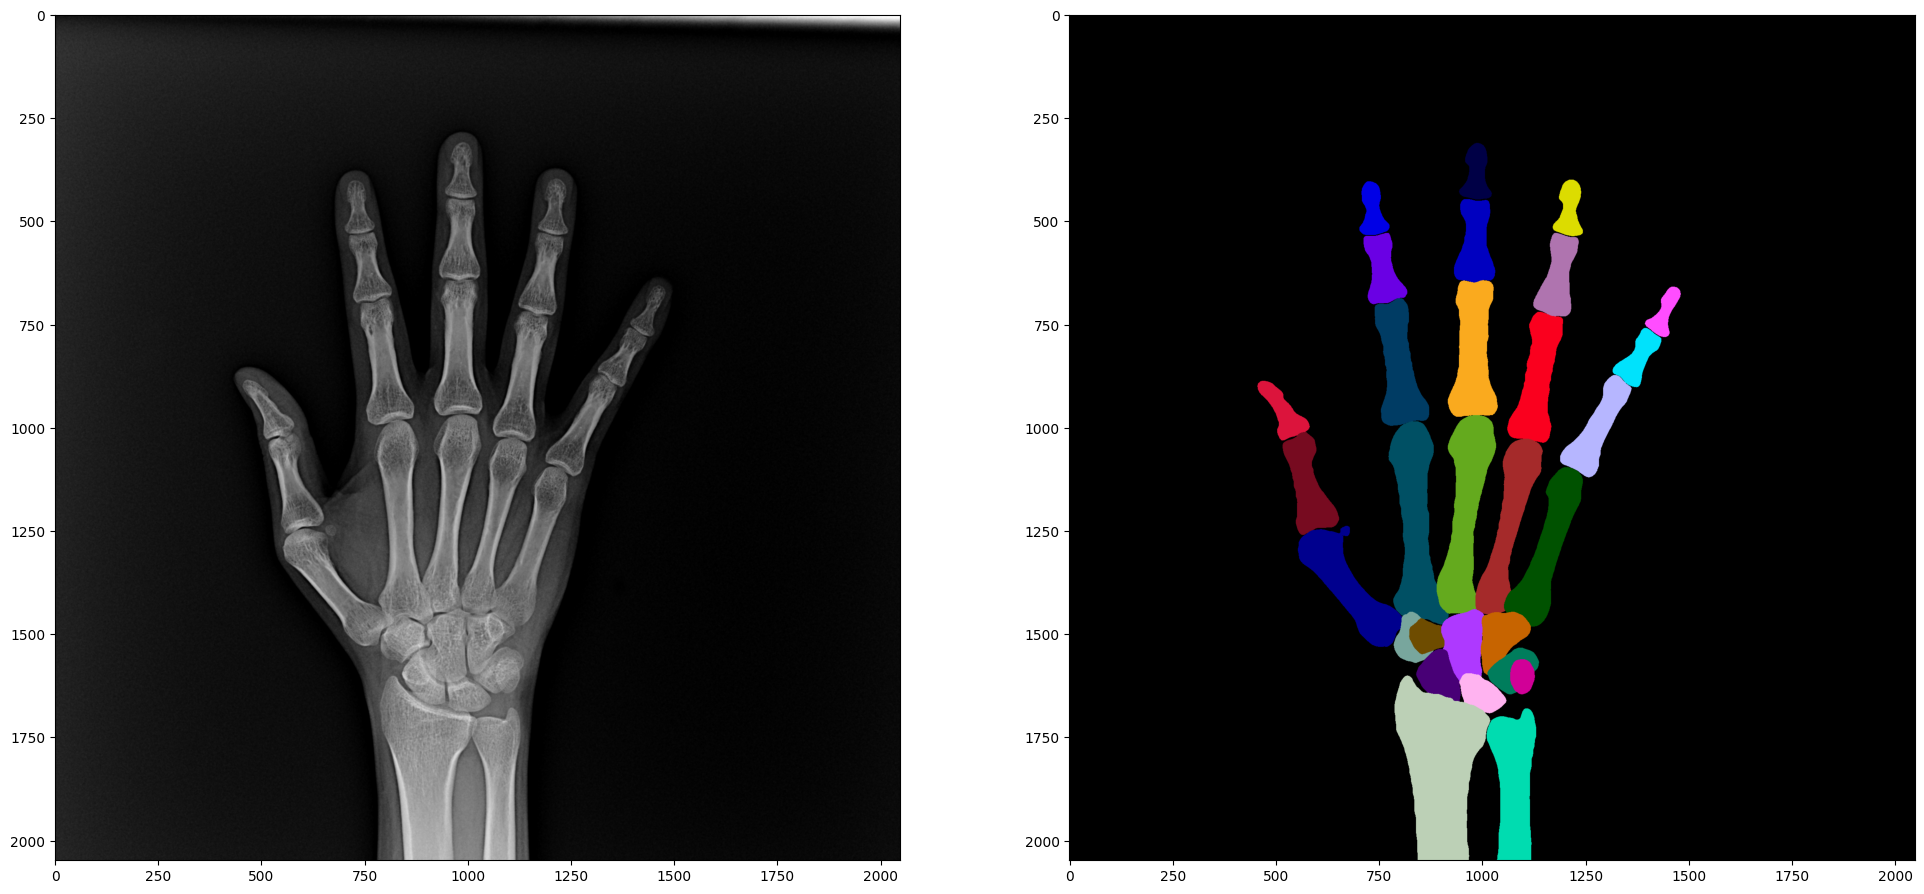

: 

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))
ax[0].imshow(image)    # remove channel dimension
ax[1].imshow(label2rgb(preds))

plt.show()

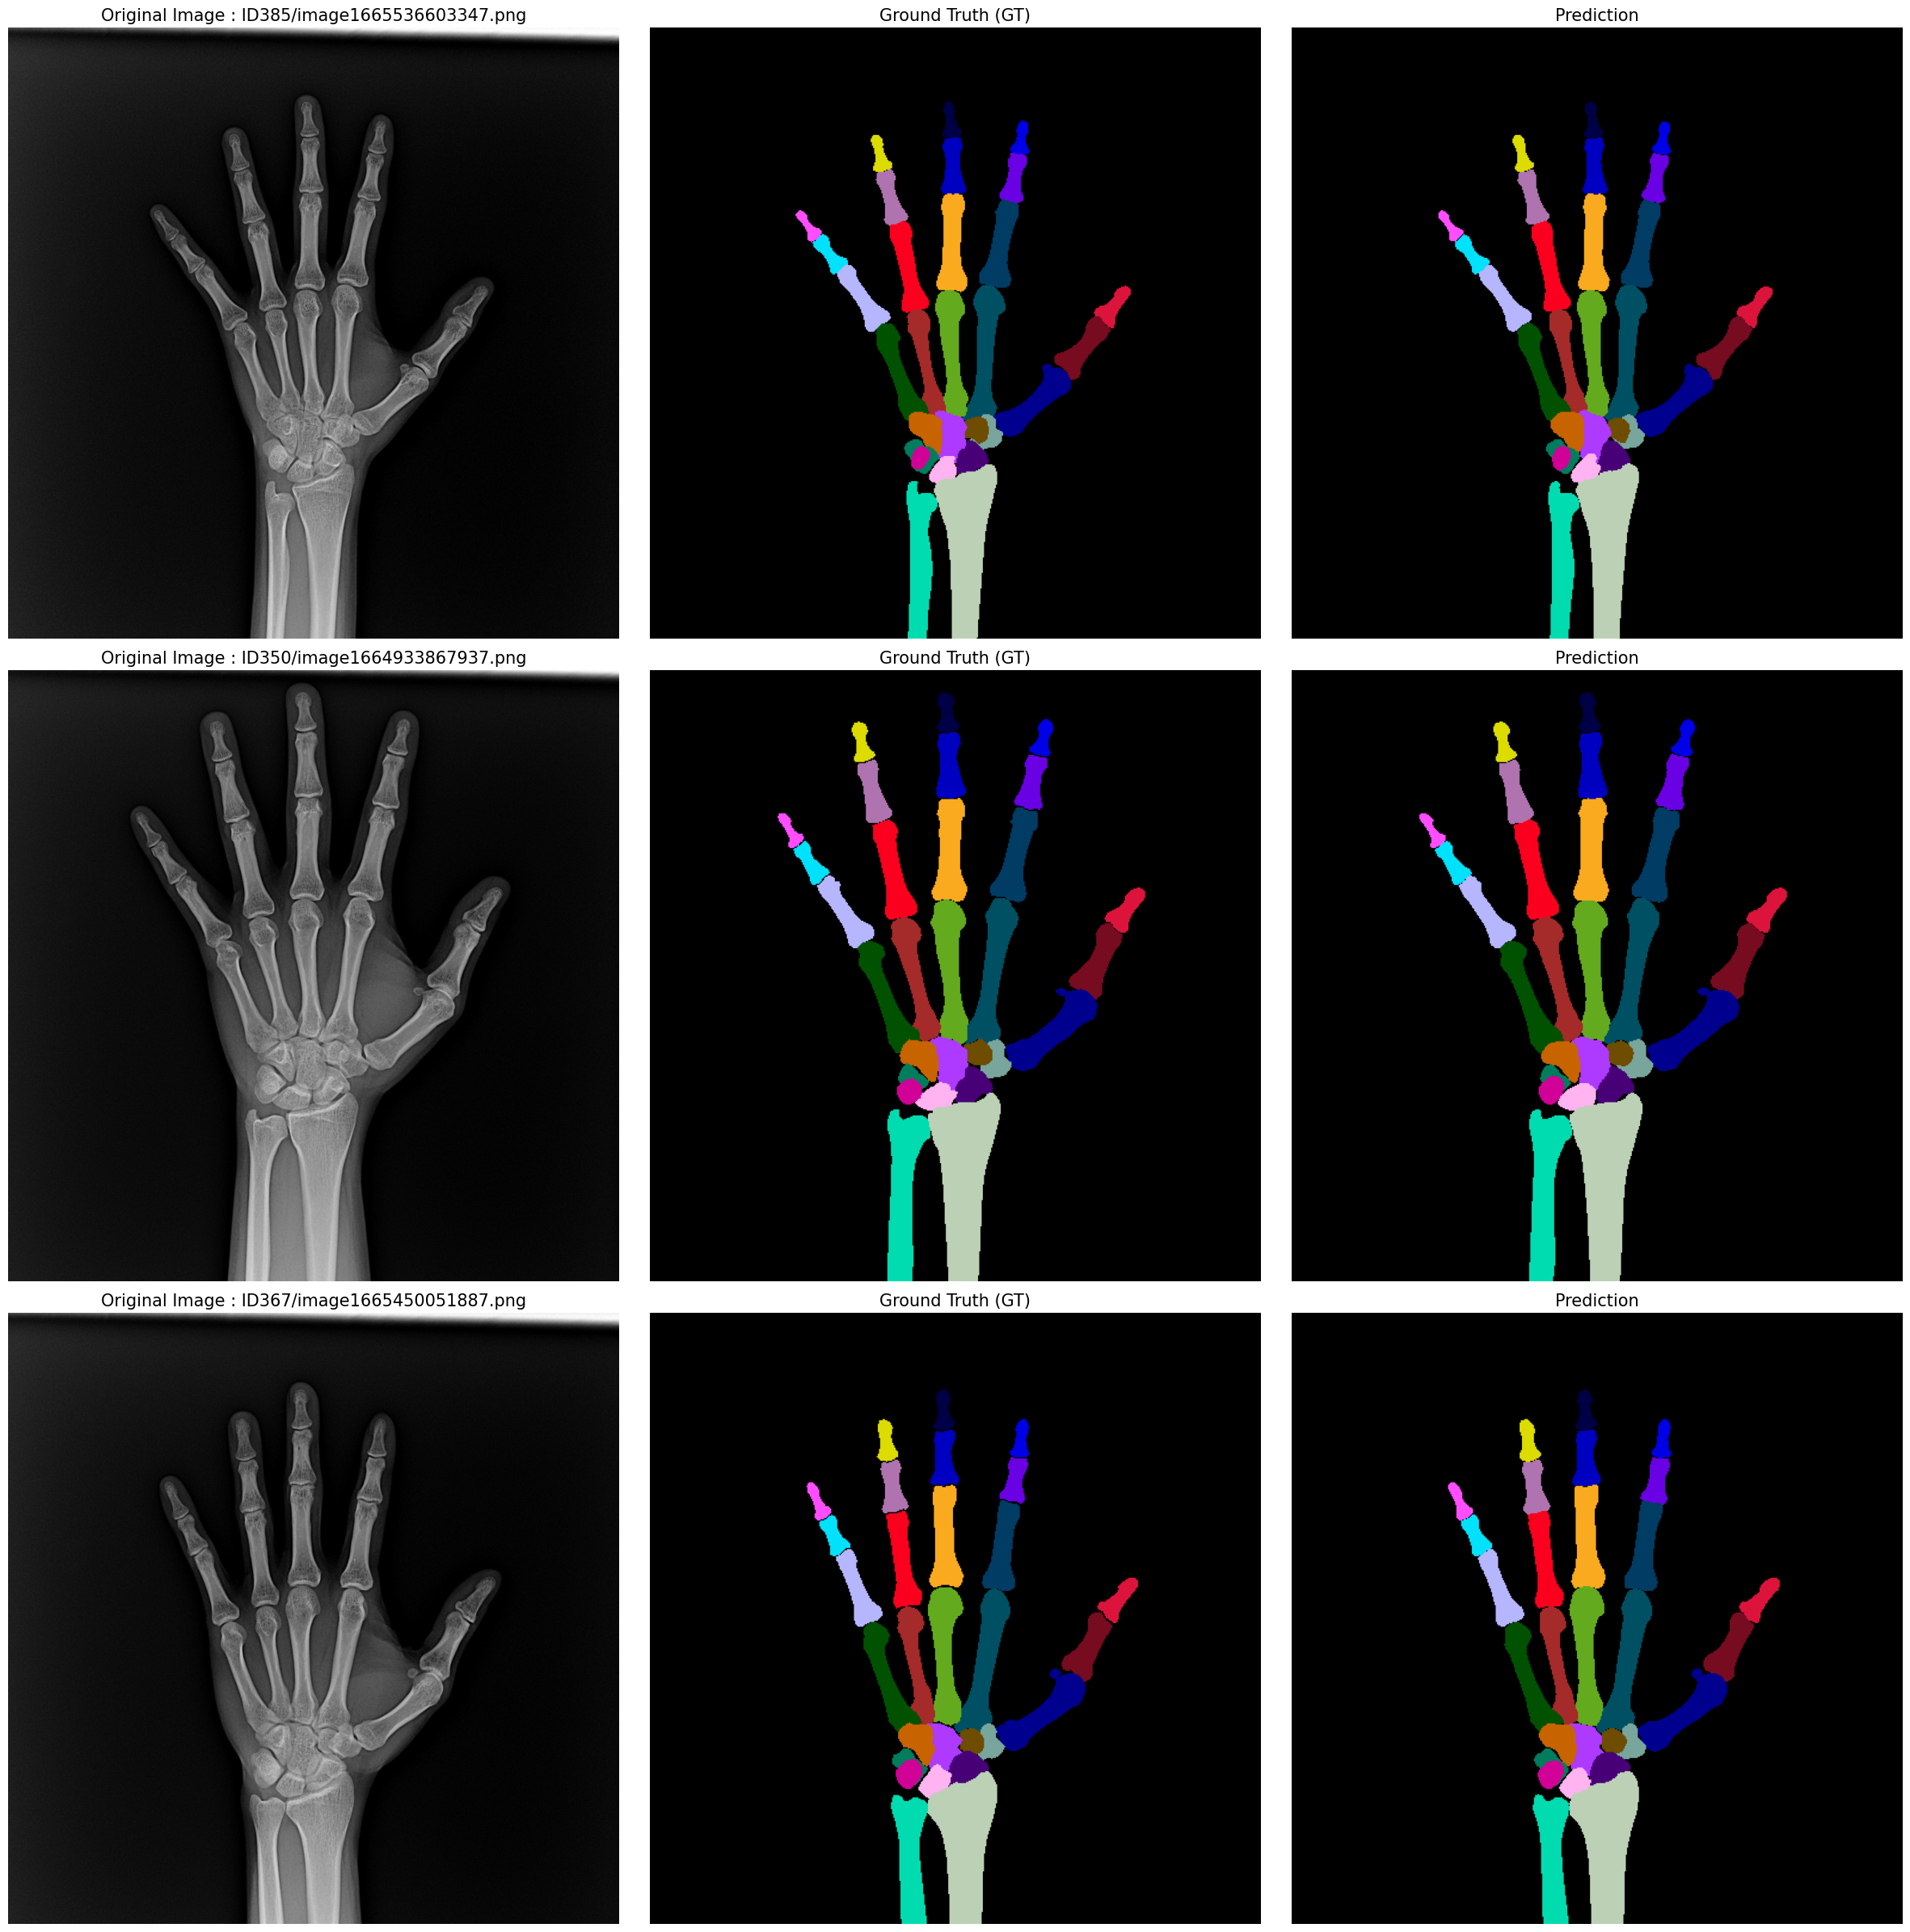

: 

In [ ]:
# 시각화할 샘플 개수
N_SAMPLES = 3

# 데이터셋에서 랜덤하게 3개 인덱스 선택
indices = np.random.choice(len(valid_dataset), N_SAMPLES, replace=False)

fig, axes = plt.subplots(N_SAMPLES, 3, figsize=(24, 8 * N_SAMPLES))

for i, idx in enumerate(indices):
    # 1. 데이터 가져오기
    image_name = valid_dataset.filenames[idx]
    
    # [수정] dataset 객체가 알고 있는 image_root를 사용하는 것이 가장 안전합니다.
    # 만약 valid_dataset.image_root 접근이 안된다면 TRAIN_IMAGE_ROOT를 쓰세요.
    image_path = os.path.join(valid_dataset.image_root, image_name)
    
    # 2. 원본 이미지 읽기 (Original)
    original_img = cv2.imread(image_path)
    
    # 혹시라도 경로가 틀렸을 경우를 대비한 디버깅 코드
    if original_img is None:
        print(f"Error: Image not found at {image_path}")
        continue
        
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    
    # 3. Ground Truth 마스크 (Label)
    _, gt_mask_tensor = valid_dataset[idx] # (C, H, W)
    gt_mask_np = gt_mask_tensor.numpy()
    
    # GT를 RGB로 변환 (채널 인덱스를 픽셀 값으로 변환 -> 컬러맵 적용)
    gt_rgb = label2rgb(gt_mask_np) 
    
    # 4. Prediction (Model Output)
    model.eval()
    with torch.no_grad():
        # 원본 이미지를 모델 입력 크기(1024)로 변환
        transform_result = valid_tf(image=original_img)
        img_tensor = transform_result["image"].unsqueeze(0).cuda() # (1, C, H, W)
        
        output = model(img_tensor)
        
        # Sigmoid + Threshold 적용
        pred_mask = torch.sigmoid(output).cpu().numpy()[0] # (C, H, W)
        pred_mask = (pred_mask > 0.5).astype(np.uint8)
        
    # Pred를 RGB로 변환
    pred_rgb = label2rgb(pred_mask)

    # 5. Plotting
    # Row i, Col 0: Original (Resize 되기 전 2048일 수 있음)
    axes[i, 0].imshow(original_img)
    axes[i, 0].set_title(f"Original Image : {image_name}", fontsize=15)
    axes[i, 0].axis("off")
    
    axes[i, 1].imshow(gt_rgb)
    axes[i, 1].set_title("Ground Truth (GT)", fontsize=15)
    axes[i, 1].axis("off")
    
    axes[i, 2].imshow(pred_rgb)
    axes[i, 2].set_title("Prediction", fontsize=15)
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()


# To CSV

In [ ]:
classes, filename = zip(*[x.split("_") for x in filename_and_class])

: 

In [ ]:
image_name = [os.path.basename(f) for f in filename]

: 

In [ ]:
df = pd.DataFrame({
    "image_name": image_name,
    "class": classes,
    "rle": rles,
})

: 

In [ ]:
df.head(30)

,image_name,class,rle
0,image1661319116107.png,finger-1,1819091 10 1821136 18 1823183 22 1825230 26 18...
1,image1661319116107.png,finger-2,2073143 9 2075187 14 2077232 18 2079279 20 208...
2,image1661319116107.png,finger-3,2538142 6 2540188 10 2542234 14 2544279 17 254...
3,image1661319116107.png,finger-4,830163 10 832209 16 834256 19 836303 22 838350...
4,image1661319116107.png,finger-5,1086206 9 1088251 13 1090295 18 1092339 22 109...
5,image1661319116107.png,finger-6,1409821 10 1411866 15 1413912 19 1415958 21 14...
6,image1661319116107.png,finger-7,2020157 18 2022201 24 2024246 30 2026291 35 20...
7,image1661319116107.png,finger-8,639962 7 642007 14 644053 18 646100 21 648147 ...
8,image1661319116107.png,finger-9,918461 15 920507 22 922554 26 922607 5 924601 ...
9,image1661319116107.png,finger-10,1319914 3 1321915 5 1321957 16 1323959 14 1324...


: 

In [ ]:
df.to_csv("output.csv", index=False)

: 

In [ ]:
import torch
import numpy as np
from tqdm.auto import tqdm
import segmentation_models_pytorch as smp

# 1. 모델 로드 (동일)
model = smp.UnetPlusPlus(
    encoder_name="se_resnext101_32x4d",
    encoder_weights=None,
    in_channels=3,
    classes=len(CLASSES),
)
ckpt = torch.load("checkpoints/best_model.pt")
model.load_state_dict(ckpt["model_state_dict"] if "model_state_dict" in ckpt else ckpt)
model = model.cuda().eval()

thr = 0.5
num_classes = len(CLASSES)

tp_sum = np.zeros(num_classes, dtype=np.float64)
fp_sum = np.zeros(num_classes, dtype=np.float64)
fn_sum = np.zeros(num_classes, dtype=np.float64)

with torch.no_grad():
    for images, masks in tqdm(val_loader, total=len(val_loader)):
        images = images.cuda()
        masks = masks.cuda()  # (B,C,H,W)

        outputs = model(images)
        h, w = outputs.size(-2), outputs.size(-1)
        mh, mw = masks.size(-2), masks.size(-1)
        if h != mh or w != mw:
            outputs = torch.nn.functional.interpolate(
                outputs, size=(mh, mw), mode="bilinear"
            )

        probs = torch.sigmoid(outputs)
        preds = (probs > thr).float()

        tp = (preds * masks).sum(dim=(0, 2, 3)).cpu().numpy()
        fp = (preds * (1 - masks)).sum(dim=(0, 2, 3)).cpu().numpy()
        fn = ((1 - preds) * masks).sum(dim=(0, 2, 3)).cpu().numpy()

        tp_sum += tp
        fp_sum += fp
        fn_sum += fn

epsilon = 1e-7
dices = (2 * tp_sum) / (2 * tp_sum + fp_sum + fn_sum + epsilon)

print(f"=== Dice per class @ thr=0.5 ===")
for c in range(num_classes):
    print(f"{CLASSES[c]:15s} | Dice: {dices[c]:.4f}")
print(f"\n>>> Mean Dice@0.5: {dices.mean():.4f}")


100%|██████████| 80/80 [01:37<00:00,  1.22s/it]

=== Dice per class @ thr=0.5 ===
finger-1        | Dice: 0.9669
finger-2        | Dice: 0.9820
finger-3        | Dice: 0.9868
finger-4        | Dice: 0.9753
finger-5        | Dice: 0.9758
finger-6        | Dice: 0.9862
finger-7        | Dice: 0.9839
finger-8        | Dice: 0.9768
finger-9        | Dice: 0.9797
finger-10       | Dice: 0.9876
finger-11       | Dice: 0.9780
finger-12       | Dice: 0.9758
finger-13       | Dice: 0.9782
finger-14       | Dice: 0.9858
finger-15       | Dice: 0.9805
finger-16       | Dice: 0.9712
finger-17       | Dice: 0.9693
finger-18       | Dice: 0.9837
finger-19       | Dice: 0.9851
Trapezium       | Dice: 0.9492
Trapezoid       | Dice: 0.9184
Capitate        | Dice: 0.9655
Hamate          | Dice: 0.9537
Scaphoid        | Dice: 0.9707
Lunate          | Dice: 0.9614
Triquetrum      | Dice: 0.9519
Pisiform        | Dice: 0.9114
Radius          | Dice: 0.9896
Ulna            | Dice: 0.9892

>>> Mean Dice@0.5: 0.9714


: 

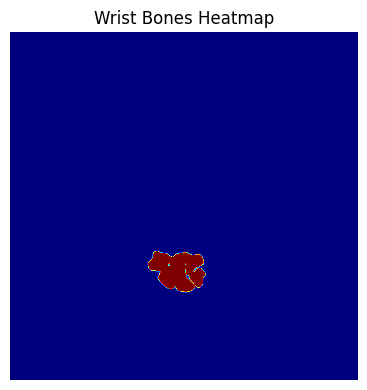

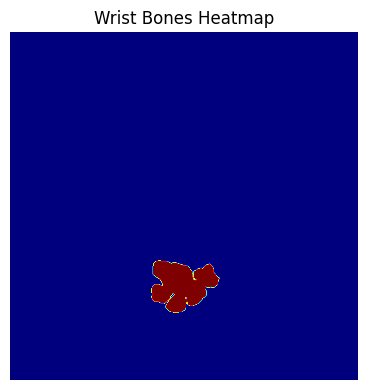

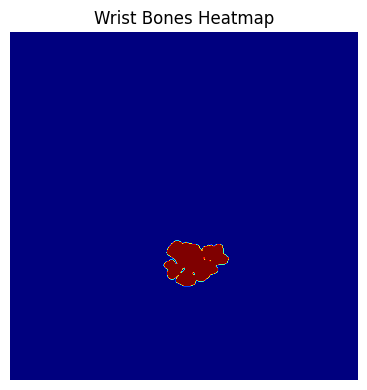

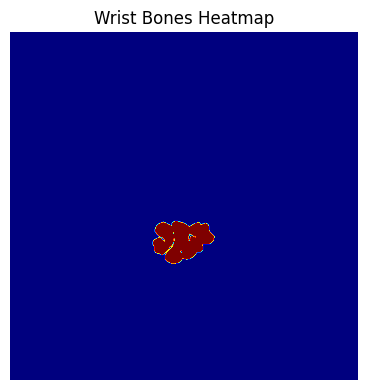

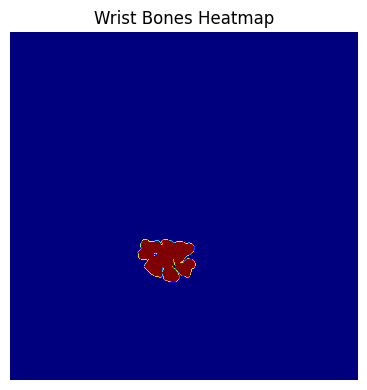

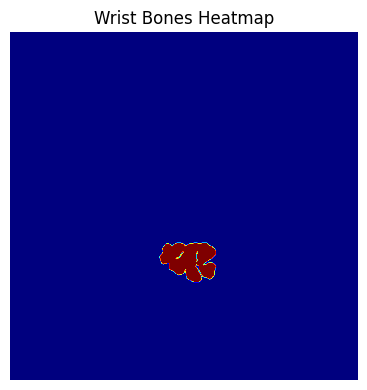

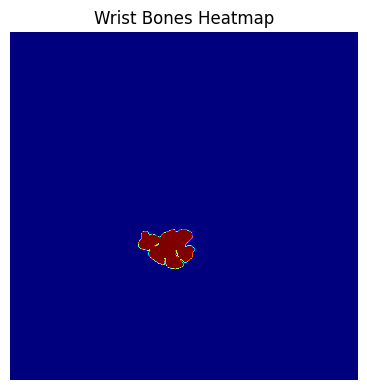

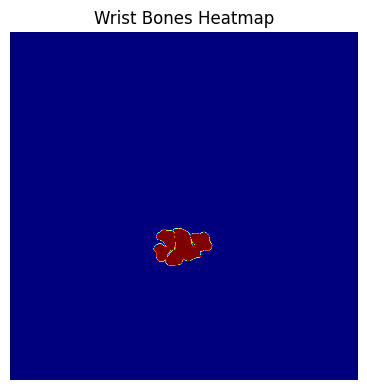

: 

In [ ]:
%matplotlib inline

import torch
import matplotlib.pyplot as plt
import numpy as np

WRIST_CLASSES = [
    "Trapezium", "Trapezoid", "Capitate", "Hamate",
    "Scaphoid", "Lunate", "Triquetrum", "Pisiform",
]
wrist_class_indices = [CLASSES.index(name) for name in WRIST_CLASSES]

num_samples = 8
count = 0

for batch_idx, (imgs, masks) in enumerate(train_loader):
    # imgs: (B, C, H, W), masks: (B, num_classes, H, W) 가정
    for i in range(imgs.size(0)):
        if count >= num_samples:
            break

        mask = masks[i]  # (C_cls, H, W)

        # 손목 뼈 채널만 합쳐서 히트맵 생성
        wrist_mask = mask[wrist_class_indices, ...]   # (num_wrist_cls, H, W)
        heatmap = wrist_mask.sum(dim=0).clamp(0, 1)  # (H, W), 0~1

        heat_np = heatmap.detach().cpu().numpy()

        plt.figure(figsize=(4, 4))
        plt.imshow(heat_np, cmap="jet")  # gray 대신 jet 등 컬러맵
        plt.title("Wrist Bones Heatmap")
        plt.axis("off")
        plt.tight_layout()
        plt.show()

        count += 1

    if count >= num_samples:
        break
